<a href="https://colab.research.google.com/github/hazanyucel/Medikal-Goruntu-Isleme-medical-image-processing-/blob/main/MedGorIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1. Gerekli kütüphaneleri kuralım
!pip install segmentation-models
!pip install nibabel

print("Kurulumlar tamamlandı.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.1 MB/s eta 0:00:00
Kurulumlar tamamlandı.


In [3]:
# 2. Kütüphaneleri import etme
import os
# Explicitly set SM_FRAMEWORK environment variable before importing segmentation_models
os.environ['SM_FRAMEWORK'] = 'tf.keras'

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib # Medikal format (.nii) okumak için
import cv2
import tensorflow as tf
# Ensure 'keras' refers to 'tf.keras' for compatibility with older libraries
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import h5py # For reading .h5 files

# Segmentation Models kütüphanesi
import segmentation_models as sm
# The set_framework call is often redundant if SM_FRAMEWORK env var is set,
# but keeping it here for explicit confirmation if desired, though the env var is more critical.
# sm.set_framework('tf.keras')
sm.framework()

print("Kütüphaneler yüklendi ve framework ayarlandı.")

Segmentation Models: using `tf.keras` framework.
Kütüphaneler yüklendi ve framework ayarlandı.


In [4]:
# 3. Google Drive Bağlantısı ve Veri Hazırlama
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def load_acdc_data(base_path, img_size=(128, 128)):
    images = []
    masks = []

    print(f"Veriler okunuyor: {base_path} ...")

    # Klasörleri gez
    for root, dirs, files in os.walk(base_path):
        for file in files:
            # .h5 uzantılı dosyaları bul
            if file.endswith('.h5'):
                file_path = os.path.join(root, file)
                try:
                    with h5py.File(file_path, 'r') as f:
                        # Corrected: Assume 'image' and 'label' keys for .h5 files
                        if 'image' in f and 'label' in f:
                            img_slice = f['image'][:]
                            mask_slice = f['label'][:]

                            # Boş (sadece siyah) maskeleri alma (Eğitimi hızlandırmak için)
                            if np.sum(mask_slice) > 0:
                                # Yeniden Boyutlandırma
                                img_slice = cv2.resize(img_slice, img_size, interpolation=cv2.INTER_LINEAR)
                                mask_slice = cv2.resize(mask_slice, img_size, interpolation=cv2.INTER_NEAREST)

                                images.append(img_slice)
                                masks.append(mask_slice)
                        else:
                            print(f"Skipping {file_path}: 'image' or 'label' datasets not found within .h5 file.")
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")

    images = np.array(images)
    masks = np.array(masks)

    # Normalizasyon (0 ile 1 arasına çekme)
    # Hata olmaması için images dizisinin boş olup olmadığını kontrol et
    if images.size > 0:
        images = (images - np.min(images)) / (np.max(images) - np.min(images) + 1e-8)
    else:
        print("Uyarı: Hiç görüntü yüklenemedi veya geçerli maske bulunamadı. Boş 'images' dizisi döndürüldü.")
        return np.array([]), np.array([]) # Boş dizi döndür

    # Boyut Genişletme: (Adet, 128, 128, 1) -> (Adet, 128, 128, 3)
    # Transfer learning modelleri genelde 3 kanal (RGB) bekler.
    images = np.expand_dims(images, axis=-1)
    images = np.repeat(images, 3, axis=-1)

    # Maskeleri One-Hot Encoding yap (4 Sınıf: Background, RV, Myo, LV)
    # Hata olmaması için masks dizisinin boş olup olmadığını kontrol et
    if masks.size > 0:
        masks = to_categorical(masks, num_classes=4)
    else:
        # Eğer maskeler boşsa, to_categorical hata verir. Boş dizi döndürülecek.
        print("Uyarı: Boş 'masks' dizisi, One-Hot Encoding yapılamadı.")
        return images, masks

    return images, masks


# ACDC veri setinin olduğu klasör yolu:
# Not: .h5 dosyaları genellikle ACDC_training_slices klasöründe bulunur.
path_to_dataset = '/content/drive/MyDrive/Medgoris/archive/ACDC_preprocessed/ACDC_training_slices' # Changed to point directly to slices

# Veriyi yükle (RAM kullanımına dikkat, img_size düşürebilirsin)
X, y = load_acdc_data(path_to_dataset, img_size=(128, 128))

# Eğitim ve Test olarak ayır
if X.size > 0 and y.size > 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Eğitim Verisi: {X_train.shape}")
    print(f"Test Verisi: {X_test.shape}")
else:
    print("Hata: Yüklenecek veri bulunamadı. Eğitim ve test setleri oluşturulamadı.")

Veriler okunuyor: /content/drive/MyDrive/Medgoris/archive/ACDC_preprocessed/ACDC_training_slices ...
Eğitim Verisi: (1480, 128, 128, 3)
Test Verisi: (370, 128, 128, 3)


In [6]:
# 4. Metrik Fonksiyonları
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1.0)

# Model Parametreleri
CLASSES = 4
EPOCHS = 30  # Deneme için düşük, proje için 50+ yapmalısın
BATCH_SIZE = 16
LR = 0.0001 # Learning Rate

print("Metrikler tanımlandı.")

Metrikler tanımlandı.


In [7]:
# --- MODEL 1: U-Net ---
print("Model 1: U-Net eğitiliyor...")

# Modeli Tanımla
model_unet = sm.Unet('resnet34', classes=CLASSES, activation='softmax', encoder_weights='imagenet')

# Derle (Compile)
model_unet.compile(
    optimizer=tf.keras.optimizers.Adam(LR),
    loss=sm.losses.DiceLoss() + sm.losses.CategoricalFocalLoss(),
    metrics=[dice_coef, sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), 'accuracy']
)

# Eğit
history_unet = model_unet.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    verbose=1
)
print("U-Net Eğitimi Tamamlandı.")

Model 1: U-Net eğitiliyor...
85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 96s 469ms/step - accuracy: 0.7368 - dice_coef: 0.4469 - f1-score: 0.2867 - iou_score: 0.2001 - loss: 0.8379 - val_accuracy: 0.9601 - val_dice_coef: 0.6190 - val_f1-score: 0.2247 - val_iou_score: 0.2041 - val_loss: 0.7973
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.9762 - dice_coef: 0.8008 - f1-score: 0.7944 - iou_score: 0.6868 - loss: 0.5948 - val_accuracy: 0.9602 - val_dice_coef: 0.8679 - val_f1-score: 0.2449 - val_iou_score: 0.2401 - val_loss: 0.7676
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.9881 - dice_coef: 0.9384 - f1-score: 0.8686 - iou_score: 0.7816 - loss: 0.3743 - val_accuracy: 0.9602 - val_dice_coef: 0.9398 - val_f1-score: 0.2449 - val_iou_score: 0.2401 - val_loss: 0.7686
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.9915 - dice_coef: 0.9761 - f1-score: 0.8977 - iou_score: 0.8232 - loss: 0.21

--- U-Net (ResNet34) Modeli İçin 10 Rastgele Örnek Gösteriliyor ---


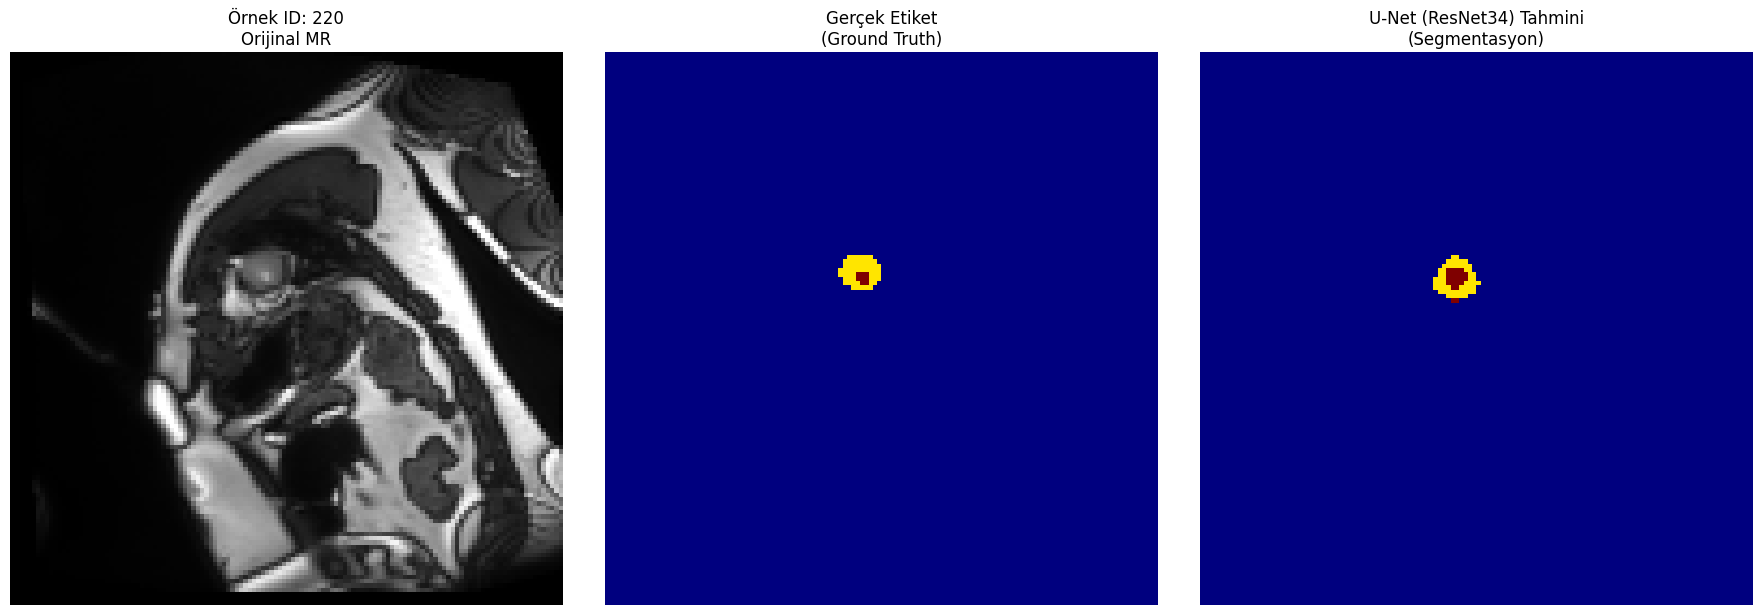

--------------------------------------------------------------------------------


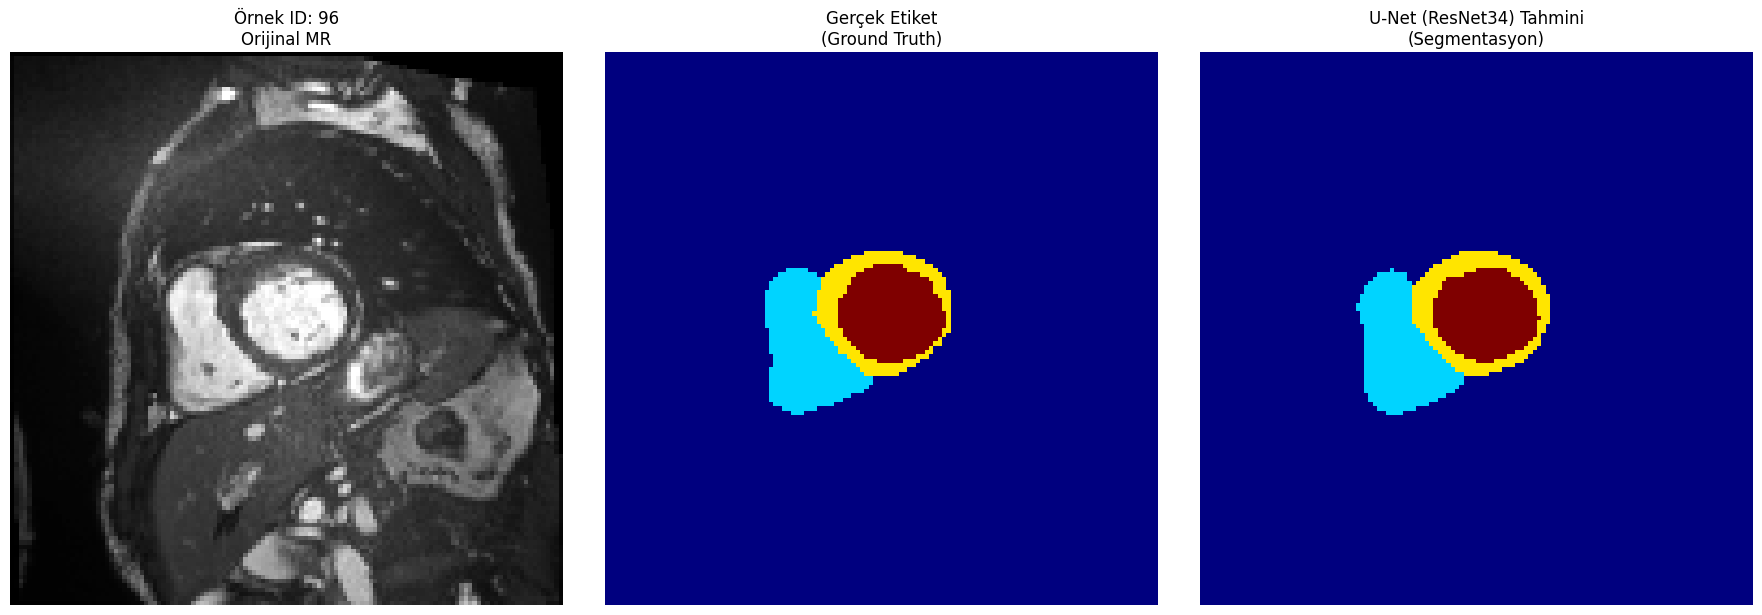

--------------------------------------------------------------------------------


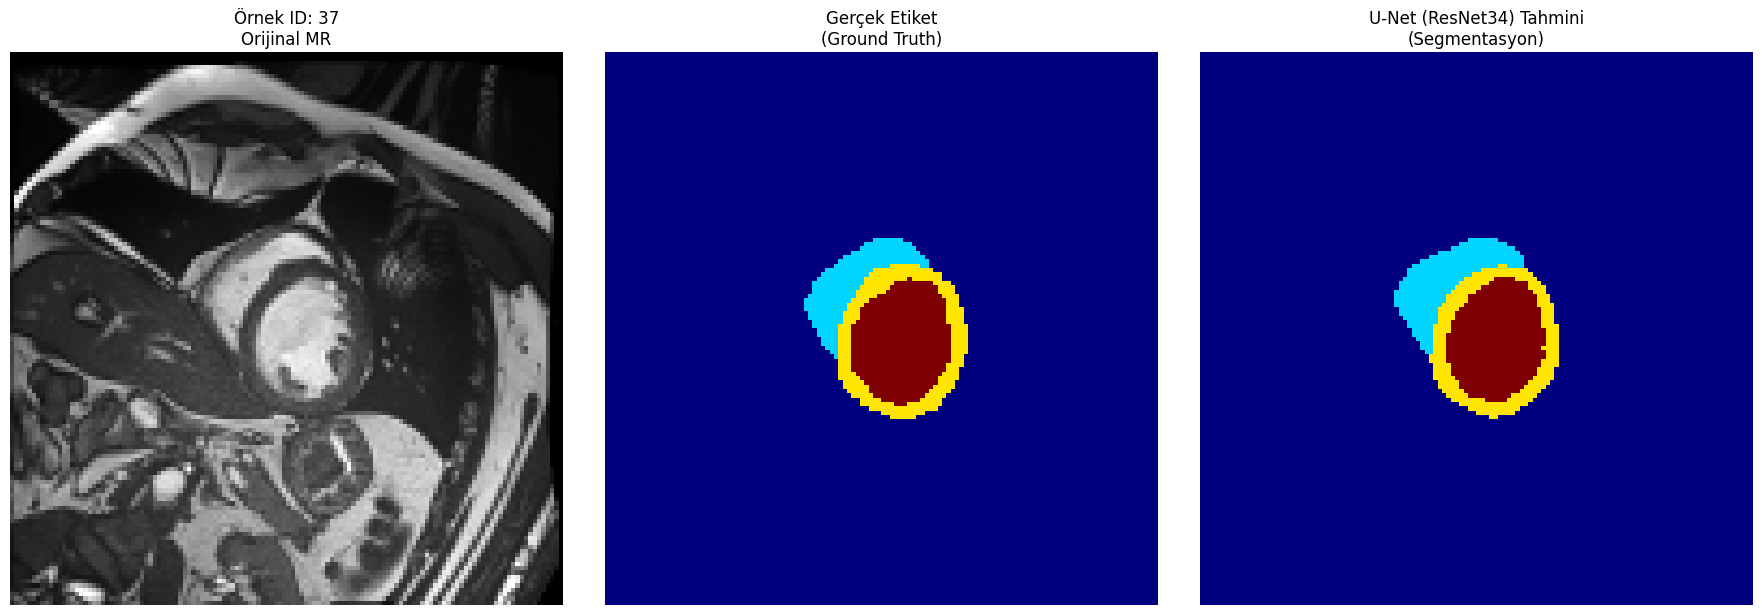

--------------------------------------------------------------------------------


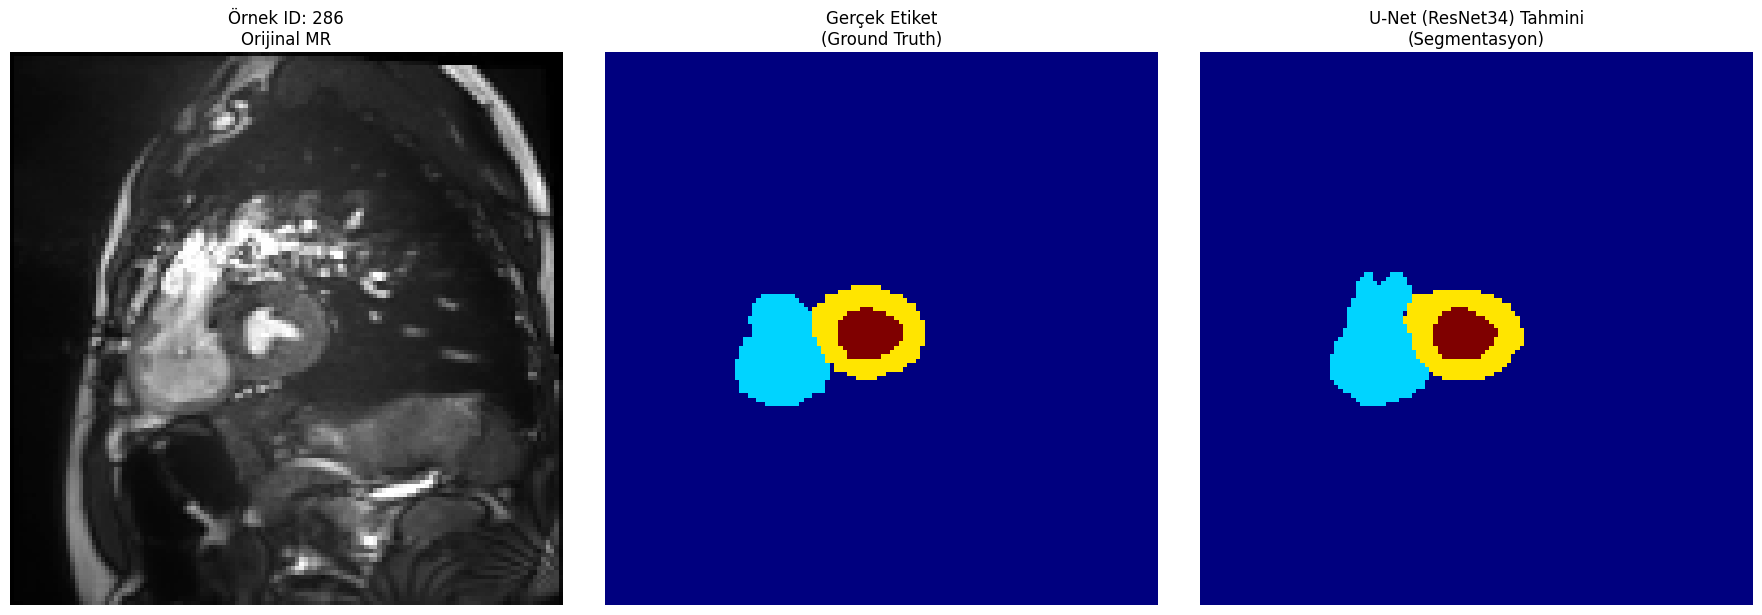

--------------------------------------------------------------------------------


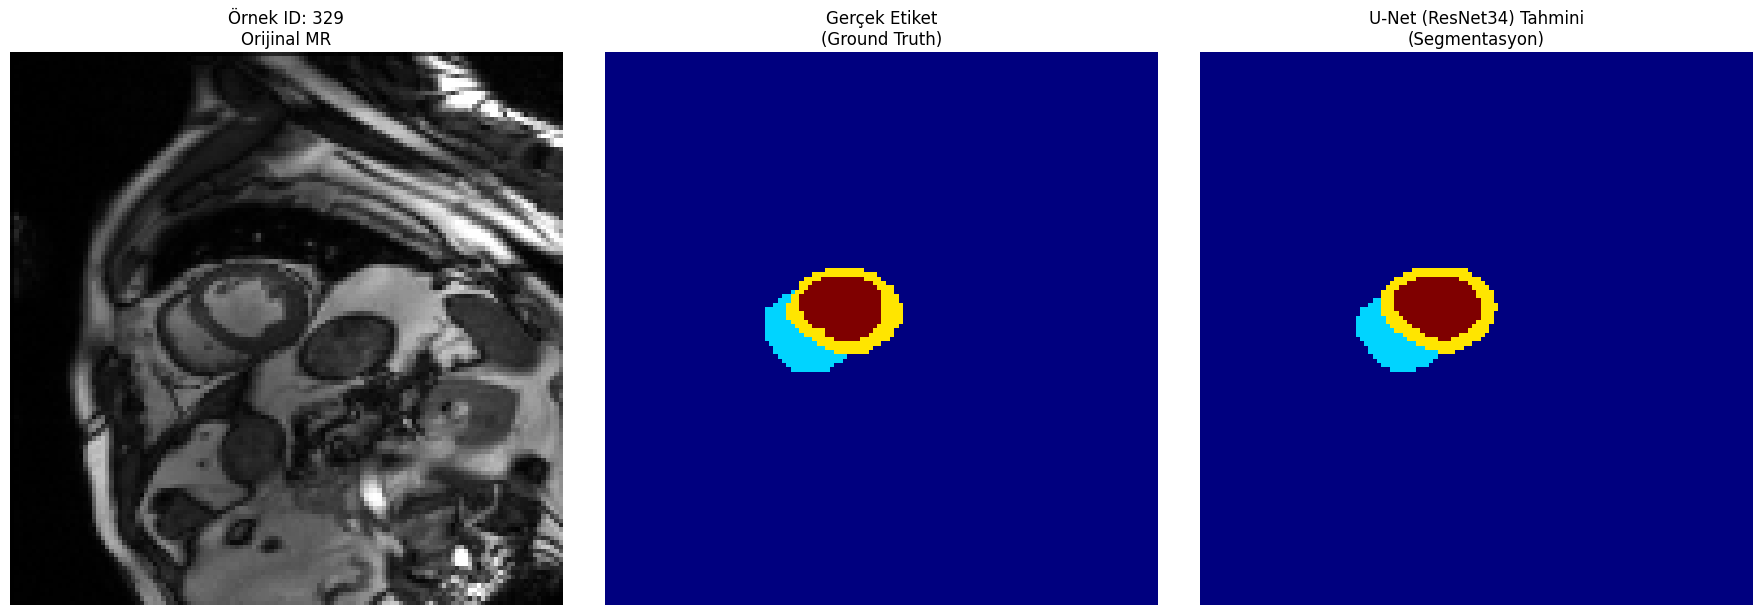

--------------------------------------------------------------------------------


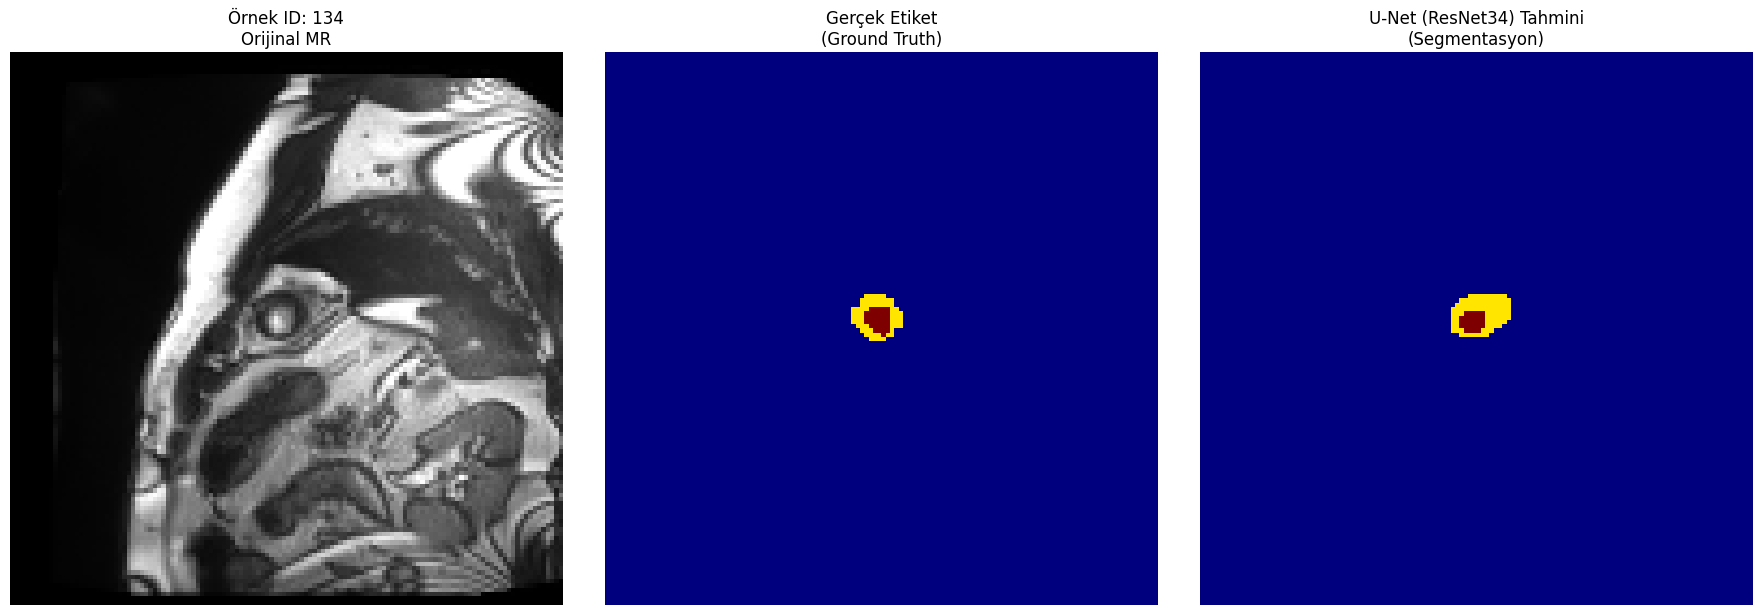

--------------------------------------------------------------------------------


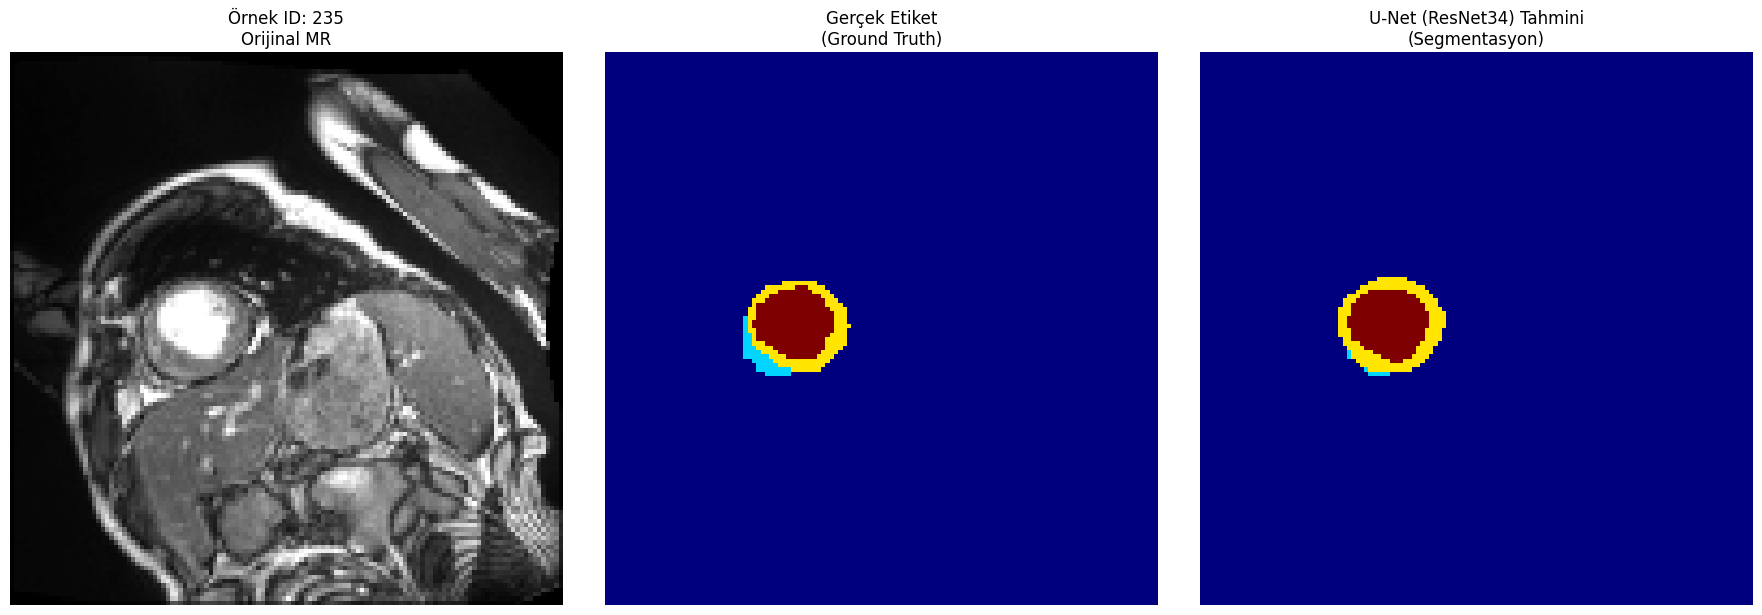

--------------------------------------------------------------------------------


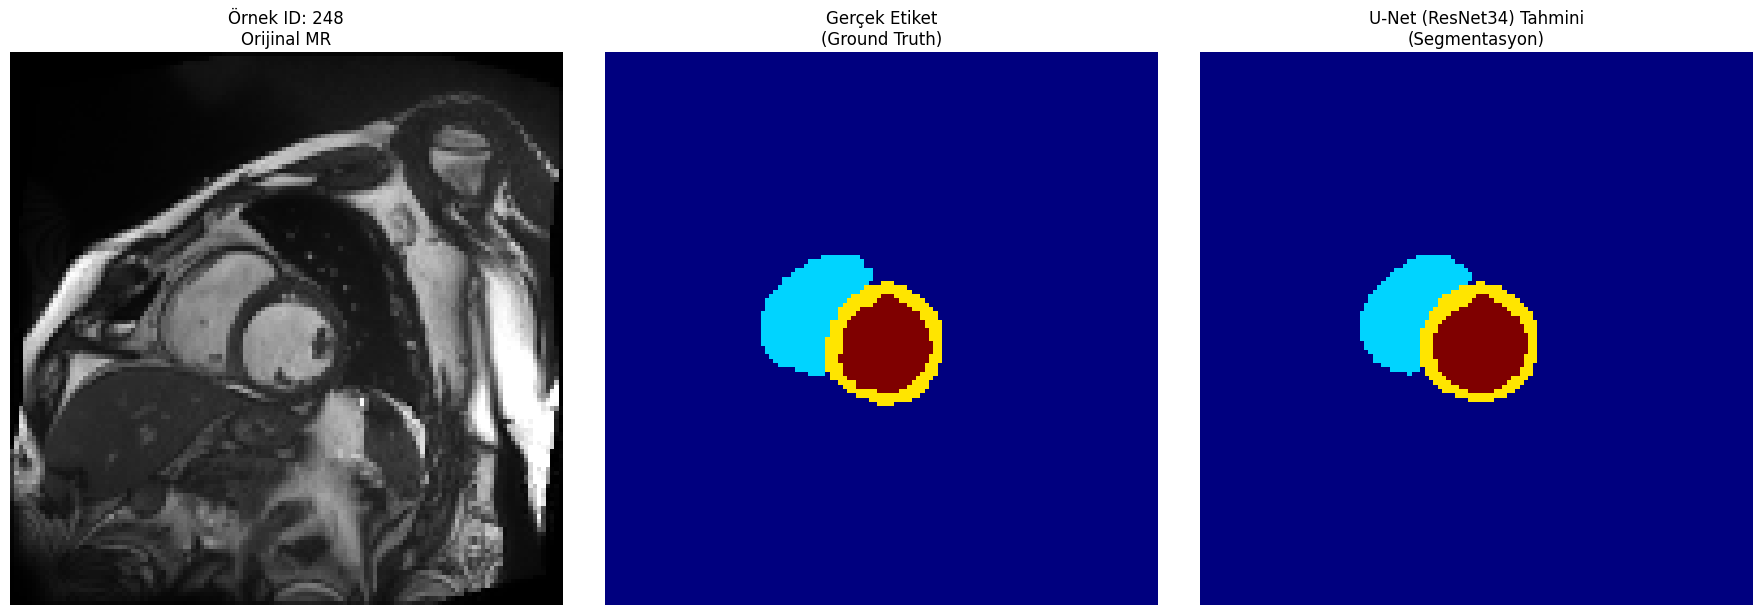

--------------------------------------------------------------------------------


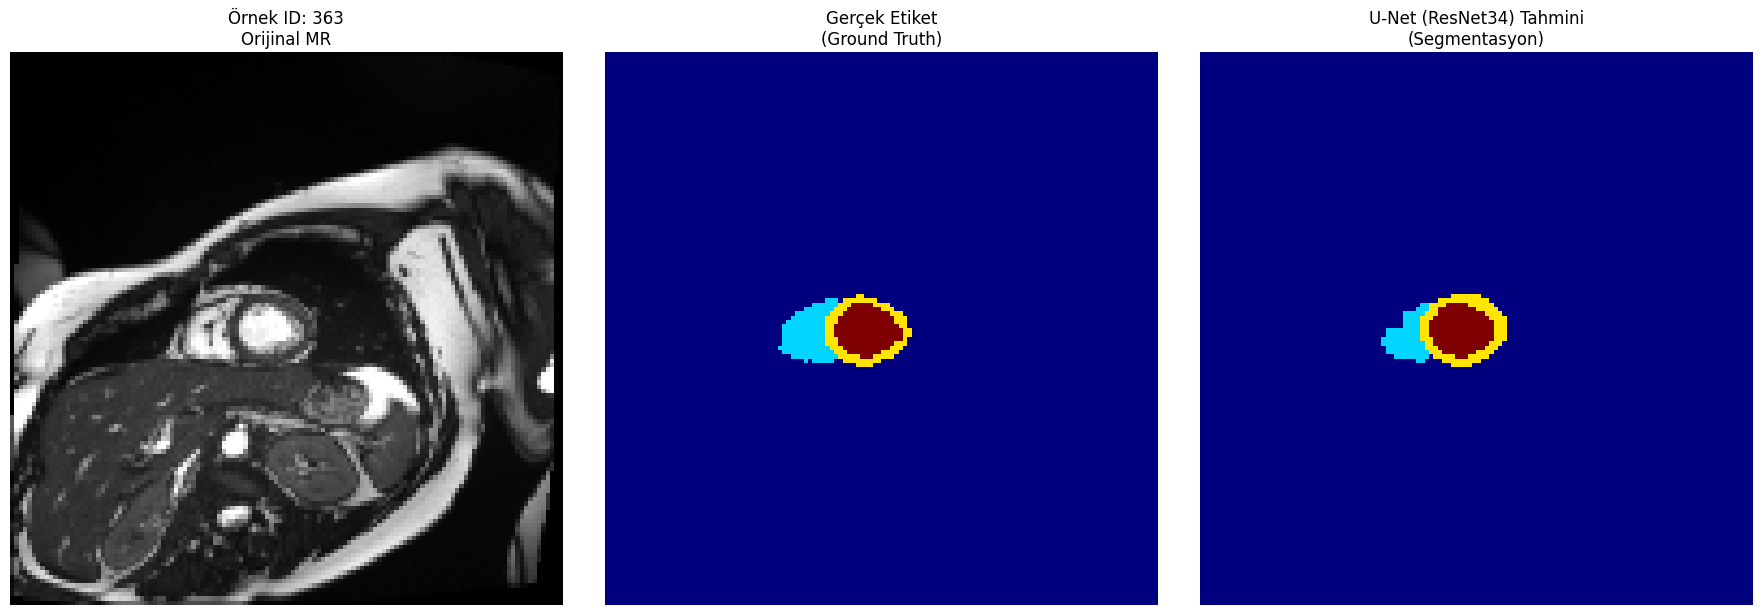

--------------------------------------------------------------------------------


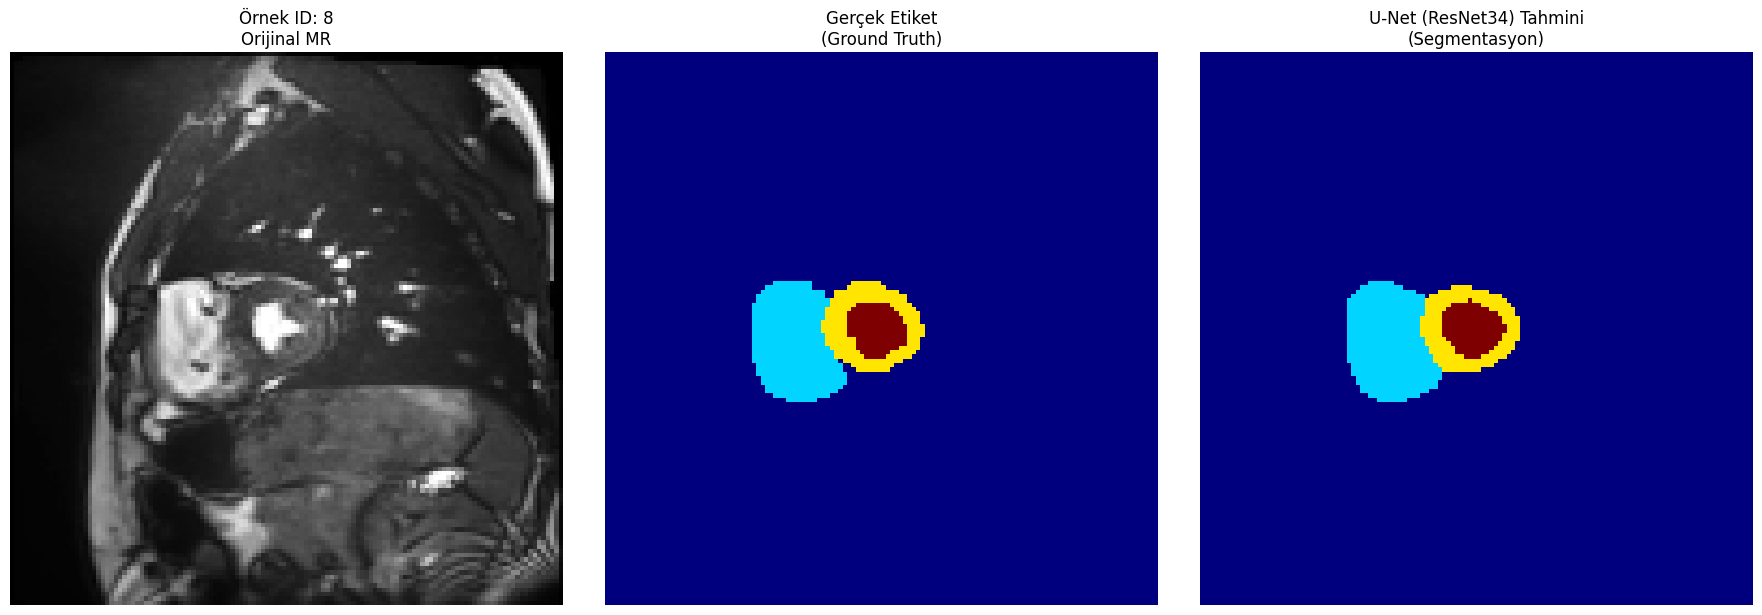

--------------------------------------------------------------------------------


In [9]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Görselleştirme Fonksiyonu
def visualize_model_predictions(model, model_name, X_test, y_test, num_samples=4):
    # Test setinden rastgele indexler seç
    # Eğer hata alırsan len(X_test) yerine manuel bir sayı (örn: 100) yazabilirsin.
    indices = random.sample(range(len(X_test)), num_samples)

    print(f"--- {model_name} Modeli İçin {num_samples} Rastgele Örnek Gösteriliyor ---")

    for i, idx in enumerate(indices):
        test_img = X_test[idx]
        # One-hot encoding'i geri çevir (Ground Truth için: 4 kanalı tek kanala indir)
        ground_truth = np.argmax(y_test[idx], axis=-1)

        # --- Tahmin Yap ---
        # Modele (Batch, H, W, Channels) formatında veri vermeliyiz, bu yüzden expand_dims kullanıyoruz
        prediction_raw = model.predict(np.expand_dims(test_img, axis=0), verbose=0)
        # Softmax çıktısından en yüksek olasılıklı sınıfı seçiyoruz
        prediction_mask = np.argmax(prediction_raw, axis=-1)[0]

        # --- Çizim ---
        plt.figure(figsize=(18, 6))

        # 1. Orijinal MR Görüntüsü (Giriş 3 kanallıydı, görselleştirme için tek kanalı alıyoruz)
        plt.subplot(1, 3, 1)
        plt.imshow(test_img[:,:,0], cmap='gray')
        plt.title(f"Örnek ID: {idx}\nOrijinal MR")
        plt.axis('off')

        # Renk haritası (cmap='jet') sınıfları belirgin gösterir.
        # vmin/vmax sınıfların (0,1,2,3) renklerinin sabit kalmasını sağlar.

        # 2. Gerçek Maske (Olması Gereken)
        plt.subplot(1, 3, 2)
        plt.imshow(ground_truth, cmap='jet', vmin=0, vmax=CLASSES-1)
        plt.title("Gerçek Etiket\n(Ground Truth)")
        plt.axis('off')

        # 3. Model Tahmini
        plt.subplot(1, 3, 3)
        plt.imshow(prediction_mask, cmap='jet', vmin=0, vmax=CLASSES-1)
        plt.title(f"{model_name} Tahmini\n(Segmentasyon)")
        plt.axis('off')

        plt.tight_layout()
        plt.show()
        # Görseller arasına çizgi çekelim
        print("-" * 80)

# Fonksiyonu çağır (model_unet şu an hafızadaki aktif model)
visualize_model_predictions(model_unet, "U-Net (ResNet34)", X_test, y_test, num_samples=10)